In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import joblib


from pandas_datareader import data as pdr

In [ ]:

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

if not firebase_admin._apps:
    cred = credentials.Certificate("firebase_key.json")
    firebase_admin.initialize_app(cred)

db = firestore.client()


In [ ]:
def load_data_from_firebase(symbol='GOOGL'):
    docs = db.collection('stocks').where('Symbol', '==', symbol).stream()
    
    data = []
    for doc in docs:
        data.append(doc.to_dict())
    
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')  
    df.set_index('Date', inplace=True)

    return df

df = load_data_from_firebase()
df.head()

In [ ]:
df = df.reset_index()
df = df.drop(['Date', 'Adj Close','Symbol'], axis=1)
df.head()

Price      Open      High       Low     Close     Volume
0      7.685977  8.015234  7.608768  8.002781  144275580
1      7.994811  8.249848  7.845375  8.170398  195364440
2      8.293184  8.487949  8.129054  8.320083  256750992
3      8.177121  8.241627  7.938772  8.019964  179600220
4      7.927067  8.099167  7.903655  8.099167  143883972


C:\Users\MARWA\AppData\Local\Temp\ipykernel_12992\1654750789.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=['Ticker', 'index'], errors='ignore')


In [58]:
df.shape

(3524, 5)

In [116]:
train_df = pd.DataFrame(df['Close'][0: int(len(df)*0.80)])
test_df = pd.DataFrame(df['Close'][int(len(df)*0.80):int(len(df))])
print(train_df.shape)
print(test_df.shape)

(2819, 1)
(705, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
joblib.dump(scaler, 'scaler.gz')

In [118]:
train_df_arr = scaler.fit_transform(train_df)
train_df_arr

array([[0.01395472],
       [0.01638965],
       [0.01856408],
       ...,
       [0.70121882],
       [0.7754732 ],
       [0.67335183]])

In [119]:
x_train = []
y_train = []
for i in range(100, train_df_arr.shape[0]):
    x_train.append(train_df_arr[i-100: i])    
    y_train.append(train_df_arr[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((2719, 100, 1), (2719,))

In [121]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=80, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=120))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=100, batch_size=32)

c:\Users\MARWA\Documents\stocks auto\auto\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - loss: 0.0805
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - loss: 0.0288
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - loss: 0.0291
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - loss: 0.0260
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - loss: 0.0283
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 334ms/step - loss: 0.0276
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - loss: 0.0252
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - loss: 0.0235
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - loss: 0.0227
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 0.0281
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 0.0230
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - loss: 0.0241
Epoch 13/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - loss: 0.0217
Epoch 14/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - loss: 0.0238
Epoch 15/100
85/85 ━━━━━━━━━━

In [122]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [ ]:
model.save('models/updatedmodel.h5')

In [ ]:
import json
with open("training_history.json", "w") as f:
    json.dump(history.history, f)

In [124]:
past_100_days = train_df.tail(100)

In [125]:
final_df = past_100_days._append(test_df, ignore_index=True)
final_df.head()

,Close
0,61.764709
1,62.582298
2,62.655949
3,62.914211
4,64.142334


In [ ]:
input_data = scaler.fit_transform(final_df)

array([[0.09629684],
       [0.10475438],
       [0.10551625],
       [0.10818785],
       [0.12089215],
       [0.10631411],
       [0.10633467],
       [0.10535663],
       [0.11228016],
       [0.12121652],
       [0.12215853],
       [0.12193716],
       [0.13013733],
       [0.13119781],
       [0.12567957],
       [0.12512869],
       [0.12459849],
       [0.13127492],
       [0.1438301 ],
       [0.13677785],
       [0.13304585],
       [0.1275224 ],
       [0.12663705],
       [0.12330646],
       [0.12946815],
       [0.13325689],
       [0.13280901],
       [0.12867025],
       [0.12083035],
       [0.12385718],
       [0.13631441],
       [0.14044291],
       [0.14684137],
       [0.14869454],
       [0.14864309],
       [0.14934321],
       [0.15152572],
       [0.15069183],
       [0.15781108],
       [0.15482025],
       [0.15328624],
       [0.15561815],
       [0.15293101],
       [0.15262739],
       [0.14943578],
       [0.15872216],
       [0.1546916 ],
       [0.147

In [127]:
input_data.shape

(805, 1)

In [128]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])    
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((705, 100, 1), (705,))

In [129]:
y_pred = model.predict(x_test)
y_pred.shape

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step


(705, 1)

In [132]:
scale = scaler.scale_
scale_factor = 1/scale
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor

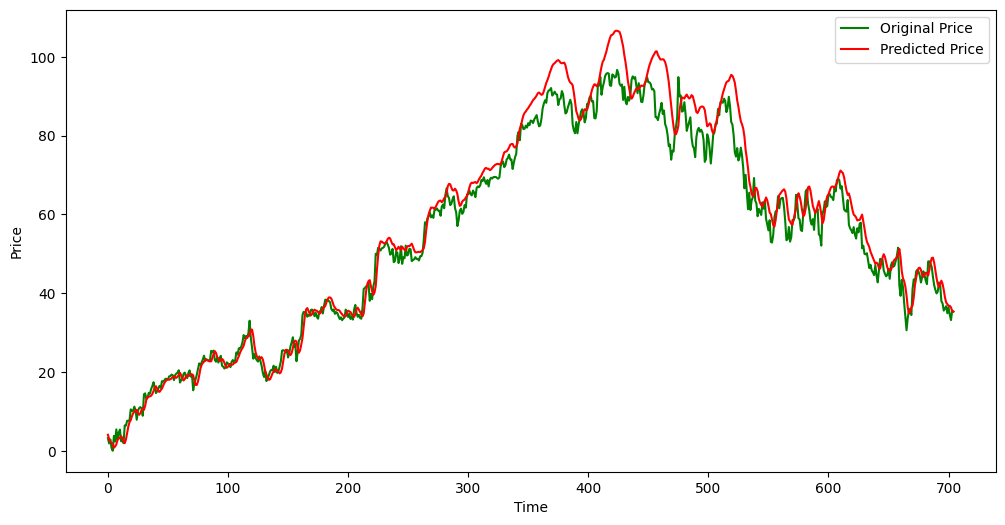

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'g', label="Original Price")
plt.plot(y_pred, 'r', label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()